<a href="https://colab.research.google.com/github/LAGISHETTYNANDITHA/Data-analysis-using-python/blob/main/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import librosa
y, sr = librosa.load('/content/drive/MyDrive/Audio_Files/Major/Major_1.wav', sr=None)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print(mfcc.shape)


(13, 194)


In [3]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

# Dataset path
dataset_path = '/content/drive/MyDrive/Audio_Files'

# Parameters
max_len = 200   # You can adjust this based on average MFCC frame count
n_mfcc = 40     # Number of MFCC features

X, y = [], []

# Feature Extraction
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith('.wav'):
                file_path = os.path.join(label_path, file)
                try:
                    signal, sr = librosa.load(file_path, sr=None)
                    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
                    mfcc = mfcc.T  # (time_steps, features)
                    if mfcc.shape[0] < max_len:
                        pad_width = max_len - mfcc.shape[0]
                        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)))
                    else:
                        mfcc = mfcc[:max_len]
                    X.append(mfcc)
                    y.append(label)
                except Exception as e:
                    print(f"❌ Skipped {file_path}: {e}")

# Convert to arrays
X = np.array(X)
y = np.array(y)

print(f"✅ Extracted features from {len(X)} files.")

# Label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, n_mfcc)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"🎯 Final Test Accuracy: {acc*100:.2f}%")


✅ Extracted features from 859 files.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 200, 40)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,082 (539.38 KB)

 Trainable params: 138,082 (539.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5408 - loss: 0.7180 - val_accuracy: 0.5756 - val_loss: 0.6817
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6018 - loss: 0.6728 - val_accuracy: 0.5756 - val_loss: 0.6780
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5745 - loss: 0.6840 - val_accuracy: 0.5756 - val_loss: 0.6735
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5962 - loss: 0.6651 - val_accuracy: 0.5756 - val_loss: 0.6751
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5489 - loss: 0.6797 - val_accuracy: 0.5756 - val_loss: 0.6756
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6076 - loss: 0.6531 - val_accuracy: 0.5872 - val_loss: 0.6720
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6016 - loss: 0.6524 - val_accuracy: 0.4709 - val_loss: 0.6870
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5391 - loss: 0.6601 - val_accuracy: 0.5756 - v

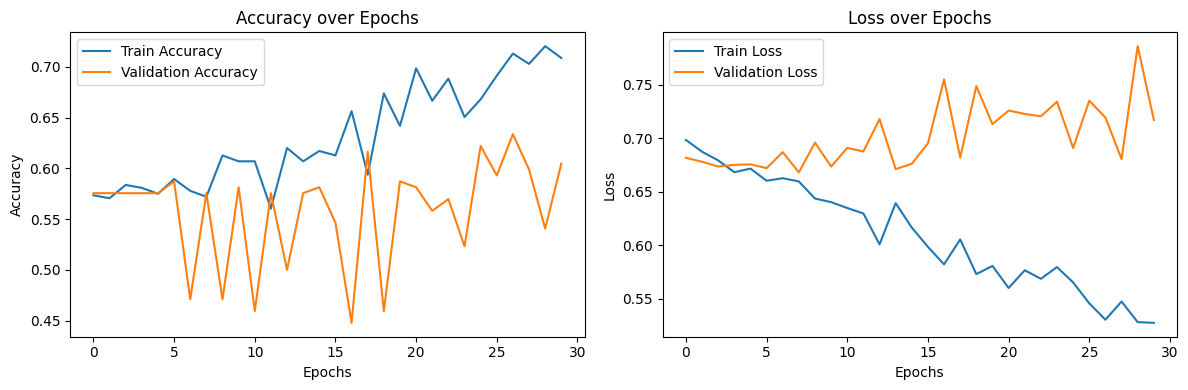

In [4]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
model.save("music_lstm_model.h5")
print("✅ Model saved as 'music_lstm_model.h5'")


✅ Model saved as 'music_lstm_model.h5'


In [6]:
def predict_genre(file_path, model, encoder, max_len=200, n_mfcc=40):
    try:
        signal, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T
        if mfcc.shape[0] < max_len:
            pad_width = max_len - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)))
        else:
            mfcc = mfcc[:max_len]
        mfcc = mfcc[np.newaxis, ...]  # Add batch dimension
        prediction = model.predict(mfcc)
        predicted_index = np.argmax(prediction)
        predicted_label = encoder.inverse_transform([predicted_index])[0]
        confidence = prediction[0][predicted_index]
        print(f"🎵 Predicted: {predicted_label} ({confidence*100:.2f}%)")
        return predicted_label
    except Exception as e:
        print(f"❌ Error predicting {file_path}: {e}")


In [7]:
predict_genre("/content/drive/MyDrive/Audio_Files/Major/Major_100.wav", model, encoder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
🎵 Predicted: Major (66.10%)


np.str_('Major')